In [1]:
%matplotlib notebook
import numpy as np
from PIL import Image

import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
#sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
#import ddm_analysis_and_fitting as ddm   

import tiff_file 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data
### usually this block prints out "nd2reader module not found. Reading of .nd2 files disabled." on the first run
### this is fine (unless you need to read .nd2 files), just re-run this block to make the error go away

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
def floodfill_flat(array, x, y, rows, cols):
    stack = []
    if array[x,y] != -1:
        return 0
    stack.append((x,y))
    currclustersize = 1
    array[x,y] = -2
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -1:
                array[xcurr-1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -1:
                array[xcurr+1,ycurr] = -2
                currclustersize += 1
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -1:
                array[xcurr,ycurr-1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -1:
                array[xcurr,ycurr+1] = -2
                currclustersize += 1
                stack.append((xcurr,ycurr+1))
    return currclustersize


def markcluster_flat(array, x, y, rows, cols, clustersize):
    stack = []
    if array[x,y] != -2:
        return
    stack.append((x,y))
    array[x,y] = clustersize
    while stack:
        xcurr, ycurr = stack.pop()
        if xcurr > 0:
            if array[xcurr-1,ycurr] == -2:
                array[xcurr-1,ycurr] = clustersize
                stack.append((xcurr-1,ycurr))
        if xcurr < rows-1:
            if array[xcurr+1,ycurr] == -2:
                array[xcurr+1,ycurr] = clustersize
                stack.append((xcurr+1,ycurr))
        if ycurr > 0:
            if array[xcurr,ycurr-1] == -2:
                array[xcurr,ycurr-1] = clustersize
                stack.append((xcurr,ycurr-1))
        if ycurr < cols-1:
            if array[xcurr,ycurr+1] == -2:
                array[xcurr,ycurr+1] = clustersize
                stack.append((xcurr,ycurr+1))

In [3]:
directory = "Z"
exp = "9-5-22_s1_theBigOne"
### "data_dir" is the pathway to the folder holding the tiff files to be analyzed 
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\"
### "plot_saveto" is the pathway to the folder where plots and results will be saved
saveto_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\threshold results\\"

files = glob.glob(data_dir+"*_t*") ### this should generate an ordered list of files in "data_dir" which have "_t" in their name
print("found %i files" % len(files))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 36 files
 0 	 row1_t01.tif
 1 	 row1_t02.tif
 2 	 row1_t03.tif
 3 	 row1_t04.tif
 4 	 row1_t05.tif
 5 	 row1_t06.tif
 6 	 row1_t07.tif
 7 	 row1_t08.tif
 8 	 row1_t09.tif
 9 	 row1_t10.tif
 10 	 row1_t11.tif
 11 	 row1_t12.tif
 12 	 row2_t01.tif
 13 	 row2_t02.tif
 14 	 row2_t03.tif
 15 	 row2_t04.tif
 16 	 row2_t05.tif
 17 	 row2_t06.tif
 18 	 row2_t07.tif
 19 	 row2_t08.tif
 20 	 row2_t09.tif
 21 	 row2_t10.tif
 22 	 row2_t11.tif
 23 	 row2_t12.tif
 24 	 row3_t01.tif
 25 	 row3_t02.tif
 26 	 row3_t03.tif
 27 	 row3_t04.tif
 28 	 row3_t05.tif
 29 	 row3_t06.tif
 30 	 row3_t07.tif
 31 	 row3_t08.tif
 32 	 row3_t09.tif
 33 	 row3_t10.tif
 34 	 row3_t11.tif
 35 	 row3_t12.tif


In [4]:
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
### array containing the name for each frame in a tiff file to be run 
### e.g. frame 1 is an image of the "50% bKaiB" condition, frame 2 is an image of the "35% bKaiB" condition, etc.

time_array = [0.67, 3.67, 6.67, 10, 12.83, 17.67, 21.67, 24.92, 28.17, 45.67, 49.08, 69.25]  
### array containing the time points corresponding to consecutive tiff files
### e.g. tiff files "bottom_row_t1", "middle_row_t1", and "top_row_t1" all correspond to t = 0.5 hrs, time_array[0]

pixel_size = 0.364 # 4*0.091 = 0.364
### pixel size (microns per pixel) of frames/ images in the tiff files --- 40x olympus objective => 0.091 um/px
### IF 2x2 BINNING: multiply the original pixel size by 2^2 = 4, e.g. 4*(0.091 um/px) = 0.364 um/px

eg_im= tiff_file.imread(files[0])
print("tiff file dimensions: "+ str(eg_im.shape))

arr_length = int((len(files))/3)
print("total number of time points: "+ str(arr_length))

font_size = 16
### font size
dpi_num = 800
### image quality level (recommendation: 600)

C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


tiff file dimensions: (5, 1440, 1920)
total number of time points: 12


In [7]:
#put your filename here
files_index = 0   #tiff_file.imread(files[0],key=[frame_key])  #'row1_t04_AE'
frame_key = 0
row = 3

if row == 1: 
    title = frame_names[frame_key] + ", t= " + str(time_array[files_index]) + " hrs, row1"
if row == 2:
    new_files_index = files_index - arr_length
    title = frame_names[frame_key] + ", t= " + str(time_array[new_files_index]) + " hrs, row2"
if row == 3:
    new_files_index = files_index - (arr_length *2)
    title = frame_names[frame_key] + ", t= " + str(time_array[new_files_index]) + " hrs, row3"

row1_title = frame_names[frame_key] + ", t= " + str(time_array[files_index]) + " hrs, row1"
row2_title = frame_names[frame_key] + ", t= " + str(time_array[files_index]) + " hrs, row2"
row3_title = frame_names[frame_key] + ", t= " + str(time_array[files_index]) + " hrs, row3"
print(row)
print(title)

IndexError: list index out of range

In [5]:
def threshold_images(im):
    imarray = np.array(im)
    rows, cols = np.shape(imarray)
    sys.setrecursionlimit(rows*cols)
    med = np.median(imarray)
    #med = np.mean(imarray)

    thresh = 1.2*med  #1.8*med
    #print(thresh)
    arraythresh = (imarray) > thresh
    threshimage = Image.fromarray(arraythresh)
    #mark unclustered pixels with -1
    marked_arraythresh = -1*(imarray > thresh)
    return threshimage, marked_arraythresh
    #return marked_arraythresh, threshimage

def testing_filtimage(image, filtersize=600):
    #image = image**1.3
    #dub_filtered = (image/100)**1.2
    dub = ((image/100)**1.5) + 1500
    print(image)
    image = (image*1.0) - ((uf(image,filtersize))*1)
    #background = (uf(image,filtersize))*1
    print(image)
    image = image + 1500
    background = (image/100)**1.4
    background = background + 1500
    print(background)
    dub_filtered = (dub*1.0) - ((uf(background,(filtersize)))*1)
    dub_filtered = dub_filtered + 1500
    print(dub_filtered)
    #image = (image*1.0) - ((uf(image,filtersize))*1)
    #n_image = n_image*2
    #image = (n_image**1.1) - ((uf(n_image,filtersize))*1)
    #image = image*2
    return image, background, dub_filtered

def filtimage(image, filtersize=600):
    #print(image)
    image = (image/100)**1.6
    image = (image*10) +1000
    #print(image)
    image = (image*1.0) - ((uf(image,filtersize))*1)
    #print(image)
    image = image + 1500

    #print(image)

    return image


<IPython.core.display.Javascript object>


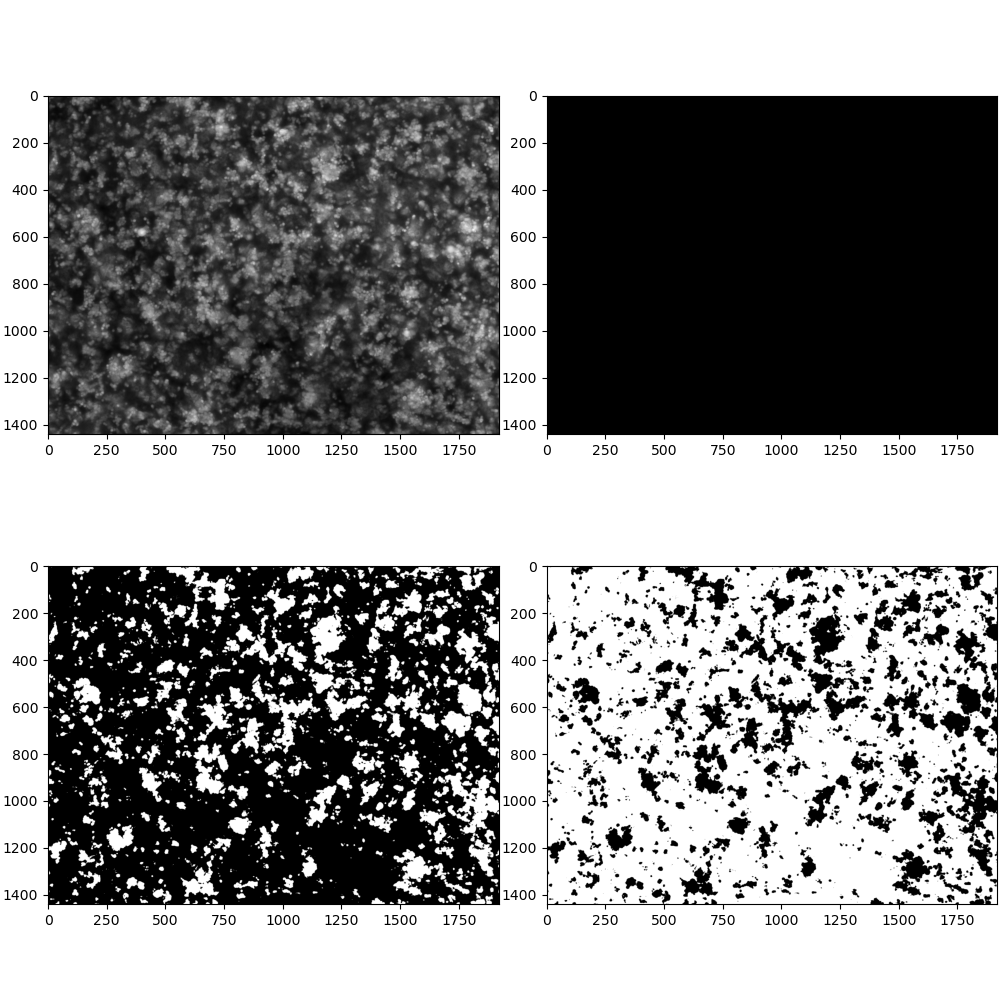

In [8]:
%matplotlib notebook
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(3,2, figsize=(10,5))
fig, axs = plt.subplots(2,2, figsize=(10,10))

raw_im = tiff_file.imread(files[7],key=[0])
clean_im = filtimage(raw_im, filtersize=0)
axs[0, 0].imshow(raw_im, cmap = 'gray')
#axs[0, 0].axis('off')
#axs[0, 0].set_title(row1_title)

axs[0, 1].imshow(clean_im, cmap = 'gray')
#axs[0, 1].axis('off')
#axs[0, 1].set_title(row1_title + " filtered")

threshimage, marked_arraythresh = threshold_images(raw_im)
filt_threshimage, filt_marked_arraythresh = threshold_images(clean_im)

#axs[1, 0].imshow(background, cmap = 'gray')
axs[1, 0].imshow(threshimage, cmap = 'gray')
#axs[1, 0].axis('off')
#axs[1, 0].set_title(row1_title + " --> threshold")

#axs[1, 1].imshow(dub_clean_im, cmap = 'gray')
axs[1, 1].imshow(marked_arraythresh, cmap = 'gray')
#axs[1, 1].axis('off')
#axs[1, 1].set_title(row1_title + " --> filtered threshold")

plt.tight_layout(pad=.2)

In [356]:
row1_ims = [0.0] * int(arr_length)
row2_ims = [0.0] * int(arr_length)
row3_ims = [0.0] * int(arr_length)

In [357]:
for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1)    ### used in plot title to specify which frame of all tiff files was analyzed
    data_file = str(time_array[i]) + " hrs" ### used in legend to show time points corresponding to each curve
    
### "im_corr" is the actual SIA function which filters, bins, and fourier transforms tiff images to generate SIA curves
    row1_ims[i] = tiff_file.imread(files[files_index], key=[frame_key])
    row2_ims[i] = tiff_file.imread(files[files_index + arr_length], key=[frame_key])
    row3_ims[i] = tiff_file.imread(files[files_index + (arr_length*2)], key=[frame_key])

NameError: name 'key' is not defined

In [372]:
def show_raw_images(row, ax, i, frame_key):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+")", fontsize=10)
    ax.imshow(raw_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

def show_filtered_images(row, ax, i, frame_key, i_num):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    filtered_image = filtimage(raw_image, filtersize= 600)
    #print(files[i+index_add])
    
    if i < i_num:
        ax.imshow(filtered_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=600)", fontsize=10)
    else:
        ax.imshow(raw_image, cmap = 'gray')
        ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+", fsize=none)", fontsize=10)
    ax.axis('off')
    plt.tight_layout(pad=.2)
    
def show_threshold_images(row, ax, i, frame_key, i_num):
    if row == 1:
        index_add = 0
    if row == 2:
        index_add = arr_length
    if row == 3:
        index_add = arr_length * 2
    raw_image = tiff_file.imread(files[i+index_add],key=[frame_key])
    #print(files[i+index_add])
    ax.set_title("~" + str(time_array[i]) + " hrs (row"+str(row)+") --> threshold", fontsize=10)
    filtered_image = filtimage(raw_image, filtersize= 600)
    if i < i_num:
        threshold_image, marked_arraythresh = threshold_images(filtered_image)
    else:
        threshold_image, marked_arraythresh = threshold_images(raw_image)
    ax.imshow(threshold_image, cmap = 'gray')
    ax.axis('off')
    plt.tight_layout(pad=.2)

condition: EA KaiC


<IPython.core.display.Javascript object>


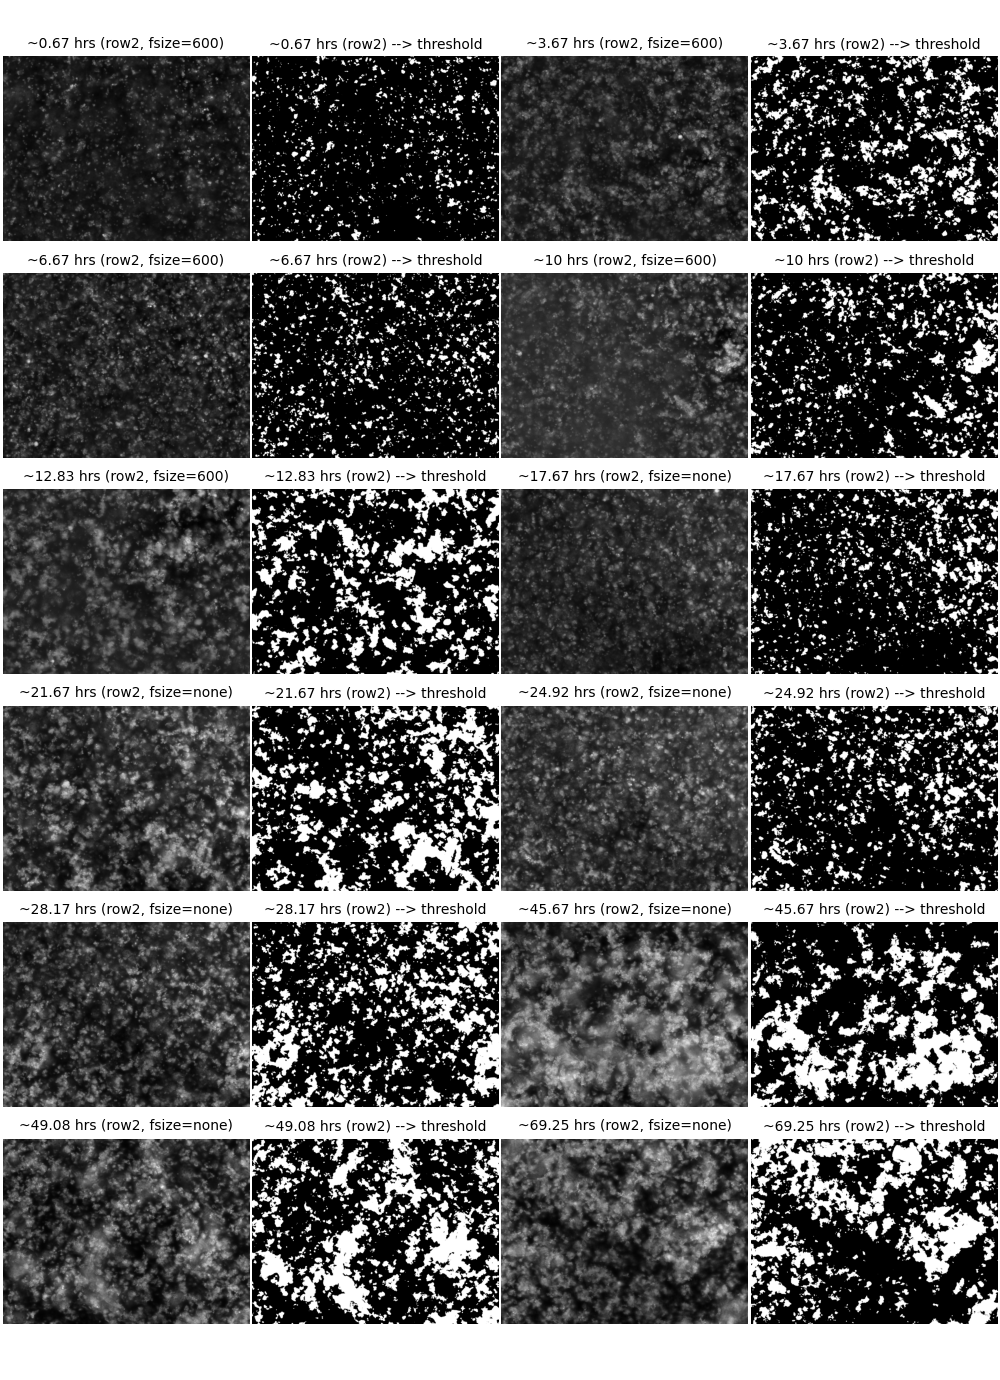

In [375]:
frame_key = 2
### "frame_key" specifies which frame of each tiff file will be analyzed (each frame of my tiff is for a different condition)
### e.g. "key = 0" dictates that the first frame of each tiff file should be analyzed

row = 2
### choose which set of tiff files should be analyzed, row1, row2 or row3

condition = frame_names[frame_key]
print("condition: "+condition)
i = 0
no_filter_i = 5
num_rows = int((len(files)/4)/3) *2
fig_height = num_rows*2.3
fig, axs = plt.subplots(num_rows, 4, figsize=(10,fig_height))
for j, ax in enumerate(axs.flatten()):
    if j % 2 == 0:
        show_filtered_images(row, ax, i, frame_key, no_filter_i)
    else:
        show_threshold_images(row, ax, i, frame_key, no_filter_i)
        i = i + 1 
plt.show()

### option to save this figure (uncomment below)
fig.savefig(saveto_dir+"ooh threshold images for "+condition+" (row"+str(row)+")"+".jpg", dpi=500)

<IPython.core.display.Javascript object>


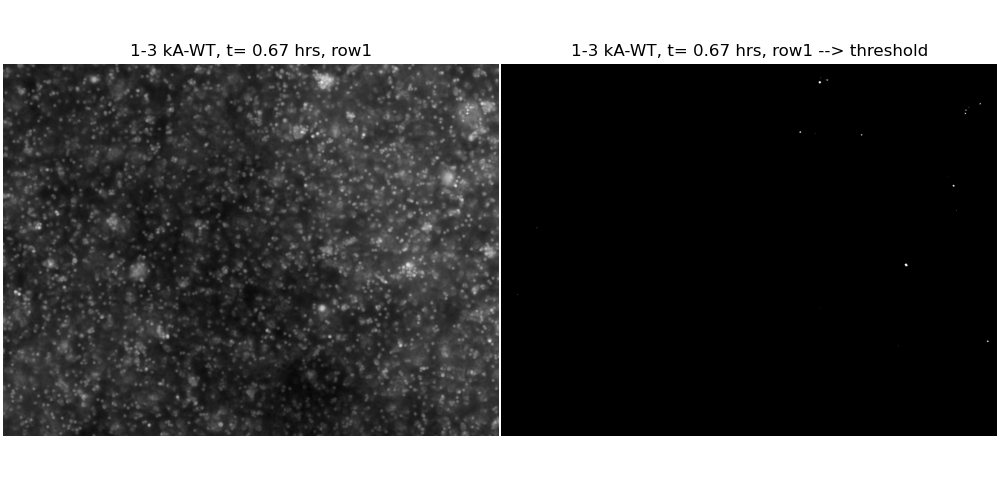

In [54]:
%matplotlib notebook
#fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(3,2, figsize=(10,5))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

im = tiff_file.imread(files[files_index],key=[frame_key])
#clean_im = filtimage(raw_im, filtersize=600)
ax1.imshow(im, cmap = 'gray')
ax1.axis('off')
ax1.set_title(row1_title)

threshimage, marked_arraythresh = threshold_images(im)


ax2.imshow(threshimage, cmap = 'gray')


ax2.axis('off')
ax2.set_title(row1_title + " --> threshold")
plt.tight_layout(pad=.2)

In [22]:
fig.savefig(saveto_dir+"threshold image for "+filename+".jpg", dpi=dpi_num)

In [ ]:



row_num = 1
def cluster_analysis(row_num, arraythresh, rows, cols):
    print('working...')
    clusters = []
    for x in range(rows):
        #if x % 25 == 0:  #progress update
        #    print(100*x/rows)
        for y in range(cols):
            if arraythresh[x,y] == -1:
                #fill in this cluster
                clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
                clusters.append(clustersize)
                #print(clustersize,x,y)
                #mark finished cluster with size
                markcluster_flat(arraythresh,x,y,rows,cols,clustersize)

    num_clusters = len(clusters)
    max_size = max(clusters)
    mean_size = sum(clusters) / len(clusters)
    avg_pixel_clustering = sum(sum(arraythresh)) / sum(sum(arraythresh > 0))

    print(num_clusters, str(row_num) + ' clusters detected')
    print(str(row_num) +' maximum cluster size: ', max_size)
    print(str(row_num) +' mean cluster size: ', mean_size)
    print(str(row_num) +' average clustering of a pixel: ', avg_pixel_clustering)
    
    return num_clusters, max_size, mean_size, avg_pixel_clustering


#display detected clusters
norm = arraythresh * 255 / np.max(arraythresh)
arraythresh = norm.astype(np.uint8)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(6,6))

imthresh = Image.fromarray(arraythresh)
ax.imshow(imthresh, cmap = 'gray')
ax.axis('off')
#imthresh.show()
#imthresh.save(filename[:-4] + '_cluster.tif')

working...
4193  clusters detected
maximum cluster size:  26483
mean cluster size:  134.25876460767947
average clustering of a pixel:  -3274.8788873552926


<ipython-input-23-5d1c5be551da>:20: RuntimeWarning: overflow encountered in long_scalars
  print('average clustering of a pixel: ', sum(sum(arraythresh)) / sum(sum(arraythresh > 0)))


<IPython.core.display.Javascript object>


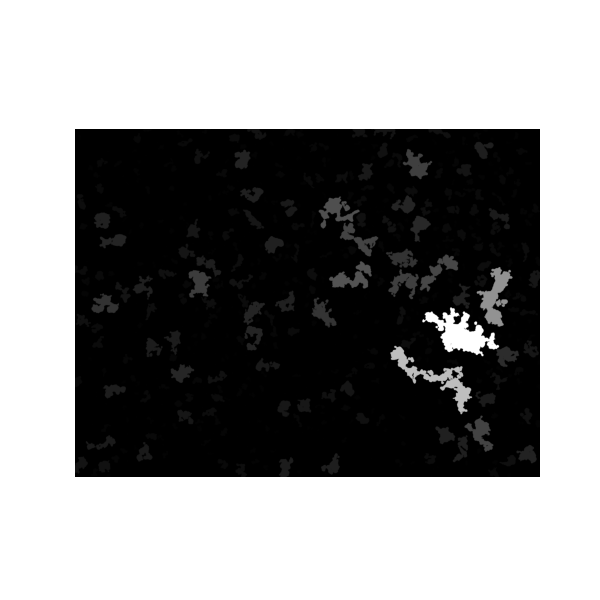

(-0.5, 1919.5, 1439.5, -0.5)

In [23]:
clusters = []

print('working...')
for x in range(rows):
    #if x % 25 == 0:  #progress update
    #    print(100*x/rows)
    for y in range(cols):
        if arraythresh[x,y] == -1:
            #fill in this cluster
            clustersize = floodfill_flat(arraythresh, x, y, rows, cols)
            clusters.append(clustersize)
            #print(clustersize,x,y)
            #mark finished cluster with size
            markcluster_flat(arraythresh,x,y,rows,cols,clustersize)

print(len(clusters), ' clusters detected')
print('maximum cluster size: ', max(clusters))
print('mean cluster size: ', sum(clusters) / len(clusters))
print('average clustering of a pixel: ', sum(sum(arraythresh)) / sum(sum(arraythresh > 0)))


#display detected clusters
norm = arraythresh * 255 / np.max(arraythresh)
arraythresh = norm.astype(np.uint8)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(6,6))

imthresh = Image.fromarray(arraythresh)
ax.imshow(imthresh, cmap = 'gray')
ax.axis('off')
#imthresh.show()
#imthresh.save(filename[:-4] + '_cluster.tif')

In [ ]:
csv_data_file = "threshold_results.csv"
data_file_exists = os.path.isfile(saveto_dir+csv_data_file)
if data_file_exists:
    print("Data file already exists.")
    with open(saveto_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow([filename, "%.4f" % alpha, "%.4f" % Dif, "%.4f" % diffusion_coeff, 
                        lower_index_for_good_q, upper_index_for_good_q])
    f.close()
    print("Results appended to file.")
else:
    print("Data file does NOT exist.")
    header = []
    np.savetxt(saveto_dir+csv_data_file, header, fmt="%s", delimiter=',')
    with open(main_dir + csv_data_file,'a', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['file name','raw alpha','raw k','k if alpha=1', 'min q index','max q index'])
        writer.writerow([filename, "%.4f" % alpha, "%.4f" % Dif, "%.4f" % diffusion_coeff, 
                        lower_index_for_good_q, upper_index_for_good_q])
    f.close()
    print("New csv created, results appended to file.")

In [ ]:
avg_cnums = all_cnums.mean(axis=0)
stderror_cnums = all_cnums.std(axis=0)/np.sqrt(3)
    row1_results[i][0]

avg_max_size = all_max_size.mean(axis=0)
stderror_max_size = all_max_size.std(axis=0)/np.sqrt(3)
    row1_results[i][1]

avg_mean_size = np.empty(len(row1_results))
stderror_mean_size = np.empty(len(row1_results))
    row1_results[i][2]

row1_results[i] = (r1_num_clusters, r1_max_size, r1_mean_size, r1_avg_pixel_clustering)